In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score, f1_score

In [2]:
species_lst = ['Coccotypes_dactyliperda', 'Hylesinus_varius', 'Monarthrum_fasciatum',
                'Phloeosinus_dentatus', 'Pityophthorus_juglandis', 'Platypus_cylindrus',
                'Pycnarthrum_hispidium', 'Scolotodes_schwarzi', 'Xyleborinus_saxesenii',
                'Xyleborus_affinis', 'Xylosandrus_compactus',
                'Xylosandrus_crassiusculus']

# get working directory
pwd = os.getcwd()
raw = r"E:\GIT_REPOS\Beetle_classifier\Data\raw\\"
data_dist = pd.read_csv(raw+"Data_distribution.csv", index_col="Species")
data_dist

,test,train,train_1,train_2,train_3,train_4,train_5,valid,valid_1,valid_2,valid_3,valid_4,valid_5
Species,,,,,,,,,,,,,
Coccotypes_dactyliperda,615,3342,3280,3458,3454,3579,3641,1011,1073,895,899,774,712
Xyleborinus_saxesenii,380,1542,1625,1663,1833,1855,1716,631,548,510,340,318,457
Pityophthorus_juglandis,680,3194,3086,3107,3219,3203,3341,795,903,882,770,786,648
Monarthrum_fasciatum,133,846,827,818,828,976,1011,269,288,297,287,139,104
Pycnarthrum_hispidium,208,1192,1146,1123,1197,1337,1413,362,408,431,357,217,141
Xyleborus_affinis,456,3127,3191,3214,3121,3388,3654,1015,951,928,1021,754,488
Scolotodes_schwarzi,467,1678,1672,1601,1664,1746,1861,458,464,535,472,390,275
Xylosandrus_crassiusculus,326,2443,2848,2828,2552,2334,2278,767,362,382,658,876,932
Hylesinus_varius,216,1312,1309,1413,1396,1369,1413,413,416,312,329,356,312


In [3]:
# WAIT FOR SIZE TO RERUN AND RERUN THIS
# VIZUALISE THE DATA FOR NOW
# LINE CHARTS ONE FOR EACH FOLD X AXIS IS THE DAT SIZE AND Y AXIS IS PERFORMANCE


In [4]:
# this function only describes how much a singular value in al ist stands out.
# if all values in the lsit are high or low this is 1
# the smaller the proportiopn of number of disimilar vlaues are to other more similar values the lower this number
# the larger the gap between the dissimilar numbers and the simialr number the smaller this number
# only able to interpret probabilities or values between 0 and 1
# this function outputs an estimate an inverse of the classification confidence based on the probabilities of all the classes.
# the wedge threshold splits the data on a threshold with a magnitude of a positive int to force a ledge/peak in the data
def unknown_prob_calc(probs, wedge_threshold=0.85, wedge_magnitude=1, wedge='strict'):
    if wedge =='strict':
        increase_var = (1/(wedge_magnitude))
        decrease_var = (wedge_magnitude)
    if wedge =='dynamic': # this allows pointsthat are furhter from the threshold ot be moved less and points clsoer to be moved more
        increase_var = (1/(wedge_magnitude*((1-np.abs(probs-wedge_threshold)))))
        decrease_var = (wedge_magnitude*((1-np.abs(probs-wedge_threshold))))
    # else:
    #     print("Error: use 'strict' (default) or 'dynamic' as options for the wedge parameter!")
    probs = np.where(probs>=wedge_threshold , probs**increase_var, probs)
    probs = np.where(probs<=wedge_threshold , probs**decrease_var, probs)
    diff_matrix = np.abs(probs[:, np.newaxis] - probs)
    diff_matrix_sum = np.sum(diff_matrix)
    probs_sum = np.sum(probs)
    class_val = (diff_matrix_sum/probs_sum)
    max_class_val = ((len(probs)-1)*2)
    kown_prob = class_val/max_class_val
    unknown_prob = 1-kown_prob
    return(unknown_prob)

In [5]:
data_size_df = pd.read_csv(r"E:\GIT_REPOS\Beetle_classifier\Data\raw\Size\csv\data_size_results.csv")
data_size_df

,fold-1_image_number,fold-2_image_number,fold-3_image_number,fold-4_image_number,fold-5_image_number
0,174,174,200,184,221
1,313,411,407,363,400
2,497,583,562,563,600
3,718,803,799,800,810
4,890,964,983,1001,986
5,1072,1146,1183,1222,1205
6,1247,1321,1358,1361,1344
7,1408,1521,1530,1516,1560
8,1615,1740,1751,1698,1742
9,1791,1916,1927,1917,1949


# Validation 

In [6]:
valid_dir = r"E:\GIT_REPOS\Beetle_classifier\Data\raw\Size\csv\valid\\"
folds = 2 # 5
size_num = 19

# get all different sized results from data
valid_dict = {}
for fold in range(1,folds+1):
    size_results_df = pd.DataFrame()
    data_size_summary_df = pd.DataFrame()
    data_size_summary_df['valid'] = data_dist["valid_"+str(fold)]
    for size in range(1,size_num+1):
        truth_df = pd.read_csv(valid_dir+str(size)+"_Validation_prediction_probabilities_fold-"+str(fold)+".csv").drop('Unnamed: 0', axis=1)
        # calculate the max class
        truth_df['pred'] = truth_df.idxmax(axis=1)

        # add truth value
        valid_series = data_dist["valid_"+str(fold)]
        truth_lst = []
        for spcs, count in valid_series.to_dict().items():
            truth_lst = truth_lst + list(np.repeat(spcs, count))
        truth_df['truth'] = truth_lst

        # get truth and pred valeus for all sizes
        size_results_df['truth_'+str(size)] = truth_df['truth']
        size_results_df['pred_'+str(size)] = truth_df['pred']
        
        
        # get the training data size df
        train_series = data_dist["train_"+str(fold)].copy()
        train_series['Coccotypes_dactyliperda']=data_size_df["fold-"+str(fold)+"_image_number"].loc[size-1]
        data_size_summary_df['train_'+str(size)] = train_series
    
    # save each dataframe as a csv
    data_size_summary_df.to_csv("valid_data_size_summary_fold_"+str(fold)+".csv")
    size_results_df.to_csv("valid_size_results_fold_"+str(fold)+".csv")
    
    # save all data to dictionary
    valid_dict["fold_"+str(fold)] = [data_size_summary_df, size_results_df]
    
# save dictionary to disk
with open('valid_dict_size.pkl', 'wb') as f:
    pickle.dump(valid_dict, f)

# Testing 

In [7]:
test_dir = r"E:\GIT_REPOS\Beetle_classifier\Data\raw\Size\csv\test\\"
folds = 2 #5
size_num = 19

# get all different sized results from data
test_dict = {}
for fold in range(1,folds+1):
    size_results_df = pd.DataFrame()
    data_size_summary_df = pd.DataFrame()
    data_size_summary_df['test'] = data_dist["test"]
    for size in range(1,size_num+1):
        truth_df = pd.read_csv(test_dir+str(size)+"_Testing_prediction_probabilities_fold-"+str(fold)+".csv").drop('Unnamed: 0', axis=1)
        # calculate the max class
        truth_df['pred'] = truth_df.idxmax(axis=1)

        # add truth value
        test_series = data_dist["test"]
        truth_lst = []
        for spcs, count in test_series.to_dict().items():
            truth_lst = truth_lst + list(np.repeat(spcs, count))
        truth_df['truth'] = truth_lst

        # get truth and pred valeus for all sizes
        size_results_df['truth_'+str(size)] = truth_df['truth']
        size_results_df['pred_'+str(size)] = truth_df['pred']
        
        
        # get the training data size df
        train_series = data_dist["train_"+str(fold)].copy()
        train_series['Coccotypes_dactyliperda']=data_size_df["fold-"+str(fold)+"_image_number"].loc[size-1]
        data_size_summary_df['train_'+str(size)] = train_series
    
    # save each dataframe as a csv
    data_size_summary_df.to_csv("test_data_size_summary_fold_"+str(fold)+".csv")
    size_results_df.to_csv("test_size_results_fold_"+str(fold)+".csv")
    
    # save all data to dictionary
    test_dict["fold_"+str(fold)] = [data_size_summary_df, size_results_df]
    
# save dictionary to disk
with open('test_dict_size.pkl', 'wb') as f:
    pickle.dump(test_dict, f)

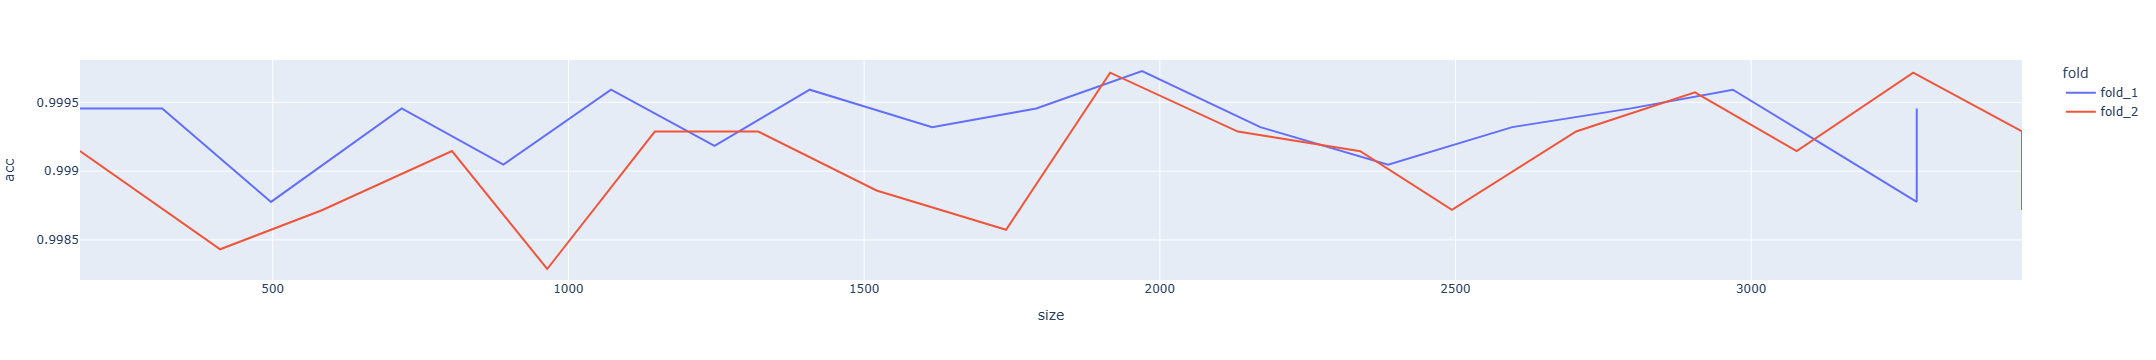

In [10]:
# create results dataframe
results_dict = valid_dict
acc_df = pd.DataFrame()
acc_lst = []
size_lst = []
fold_lst = []
folds = 2 #5
for fold in range(1,folds+1):
    # acc_lst = []
    # size_lst = []
    for i in range(1, 20):
        # data_df = results_dict['fold_'+str(fold)][1][['truth_'+str(i), 'pred_'+str(i)]]
        # data_df = data_df[data_df['truth_'+str(i)]=='Coccotypes_dactyliperda']
        acc = f1_score(y_true=results_dict['fold_'+str(fold)][1]['truth_'+str(i)], y_pred=results_dict['fold_'+str(fold)][1]['pred_'+str(i)], average='weighted')
        # acc = accuracy_score(y_true=data_df['truth_'+str(i)], y_pred=data_df['pred_'+str(i)])
        acc_lst.append(acc)
        size_lst.append(results_dict['fold_'+str(fold)][0].iloc[0,i])
        fold_lst.append('fold_'+str(fold))
acc_df["size"] = size_lst
acc_df["acc"] = acc_lst
acc_df['fold'] = fold_lst

fig = px.line(acc_df, x="size", y="acc", color='fold')
fig.show()

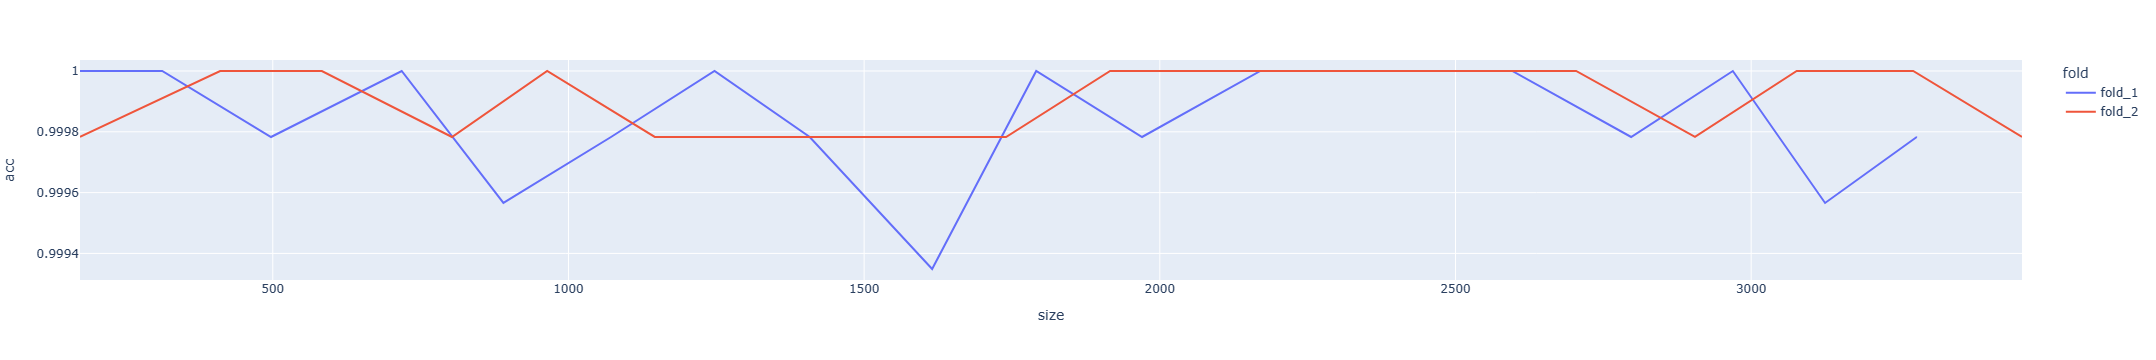

In [11]:
# create results dataframe
results_dict = test_dict
acc_df = pd.DataFrame()
acc_lst = []
size_lst = []
fold_lst = []
folds = 2 #5
for fold in range(1,folds+1):
    # acc_lst = []
    # size_lst = []
    for i in range(1, 20):
        # data_df = results_dict['fold_'+str(fold)][1][['truth_'+str(i), 'pred_'+str(i)]]
        # data_df = data_df[data_df['truth_'+str(i)]=='Coccotypes_dactyliperda']
        acc = f1_score(y_true=results_dict['fold_'+str(fold)][1]['truth_'+str(i)], y_pred=results_dict['fold_'+str(fold)][1]['pred_'+str(i)], average='weighted')
        # acc = accuracy_score(y_true=data_df['truth_'+str(i)], y_pred=data_df['pred_'+str(i)])
        acc_lst.append(acc)
        size_lst.append(results_dict['fold_'+str(fold)][0].iloc[0,i])
        fold_lst.append('fold_'+str(fold))
acc_df["size"] = size_lst
acc_df["acc"] = acc_lst
acc_df['fold'] = fold_lst

fig = px.line(acc_df, x="size", y="acc", color='fold')
fig.show()